In [411]:
import tensorflow as tf
import numpy as np

像素块随机打乱策略

In [412]:
def random_broken(inputs, radius):
    while len(inputs.shape) < 4:
        inputs = tf.expand_dims(inputs,axis=0)
    [batch_size, height, width, channels] = inputs.shape

    pool_size = [height//radius, width//radius]

    f1 = tf.split(inputs,num_or_size_splits=pool_size[0],axis=1)
    f2 = tf.split(np.array(f1),num_or_size_splits=pool_size[1],axis=3)
    temp = np.array(f2)
    
    temp = tf.reshape(np.array(f2),shape=[pool_size[1],pool_size[0],batch_size,radius*radius,channels])
    temp = tf.transpose(temp,[3,1,2,0,4])
    temp = tf.random.shuffle(temp)
    temp = tf.transpose(temp,[3,1,2,0,4])
    temp = tf.reshape(temp,shape=[pool_size[1],pool_size[0],batch_size,radius,radius,channels])
    
    cat = tf.split(temp,num_or_size_splits=pool_size[1],axis=0)
    cat = tf.concat(cat,axis=4)
    
    cat = tf.split(cat,num_or_size_splits=pool_size[0],axis=1)
    cat = tf.concat(cat,axis=3)

    out = tf.squeeze(cat)
    out = tf.expand_dims(out,axis=0)
    return out

In [413]:
import os

def imread(pth,name):
    ret = tf.io.read_file(os.path.join(pth,name))
    ret = tf.io.decode_png(ret)
    return ret

def imsave(img,name,pth):
    img = tf.io.encode_png(tf.squeeze(img))
    tf.io.write_file(os.path.join(pth,name),img)

In [414]:
from matplotlib import pyplot as plt
import numpy as np

def imshow(x, title=None, cbar=False, figsize=None):
    plt.figure(figsize=figsize)
    plt.imshow(np.squeeze(x), interpolation='nearest', cmap='gray')
    print(title)
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

In [415]:
import tensorflow as tf
import numpy as np

def guided_filter(data, guide, radius, eps):

    if data.dtype == tf.uint8:
        data = tf.cast(data/255,tf.float32)

    while len(data.shape) < 4:
        data = tf.expand_dims(data,axis=0)

    # 获取数据的形状信息
    batch, height, width, channel = tf.shape(data)[0], tf.shape(data)[1], tf.shape(data)[2], tf.shape(data)[3]

    # 对数据和引导图像进行平均值滤波
    mean_data = tf.nn.avg_pool(data, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME')
    mean_guide = tf.nn.avg_pool(guide, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME')

    # 计算方差和协方差
    mean_data_guide = tf.nn.avg_pool(data * guide, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME')
    cov_data_guide = mean_data_guide - mean_data * mean_guide

    mean_data_sq = mean_data ** 2
    mean_guide_sq = mean_guide ** 2

    # 计算引导图像的方差
    var_guide = tf.nn.avg_pool(guide ** 2, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME') - mean_guide_sq

    # 计算a和b的系数
    a = cov_data_guide / (var_guide + eps)
    b = mean_data - a * mean_guide

    # 对a和b进行平均值滤波
    mean_a = tf.nn.avg_pool(a, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME')
    mean_b = tf.nn.avg_pool(b, ksize=[1, radius, radius, 1], strides=[1, 1, 1, 1], padding='SAME')

    # 计算输出图像
    output = mean_a * guide + mean_b

    return output


In [416]:
import tensorflow as tf
import numpy as np

def gaussian_filter(data, sigma):
    
    if data.dtype == tf.uint8:
        data = tf.cast(data/255,tf.float32)

    while len(data.shape) < 4:
        data = tf.expand_dims(data,axis=0)

    ksize = int(2 * round(2 * sigma) + 1)
    x = tf.range(-ksize // 2 + 1, ksize // 2 + 1, dtype=tf.float32)
    g = tf.exp(-tf.pow(x, 2) / (2 * tf.pow(sigma, 2)))
    g = g / tf.reduce_sum(g)
    g_filter = tf.reshape(g, [ksize, 1, 1, 1]) * tf.reshape(g, [1, ksize, 1, 1])

    # 扩充维度，使其可以和输入数据进行卷积
    g_filter = tf.tile(g_filter, [1, 1, tf.shape(data)[-1], 1])

    # 对每个通道分别进行卷积操作
    output = tf.nn.depthwise_conv2d(data, g_filter, strides=[1, 1, 1, 1], padding='SAME')

    return output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


None


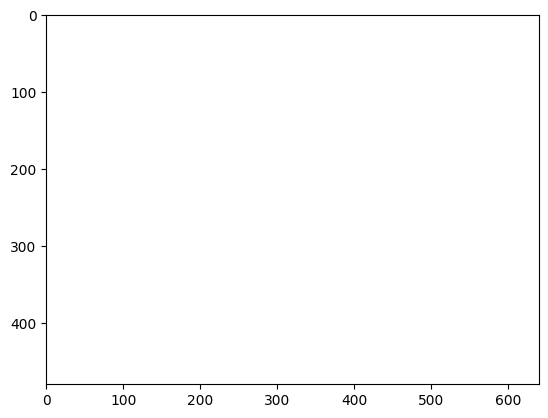

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


None


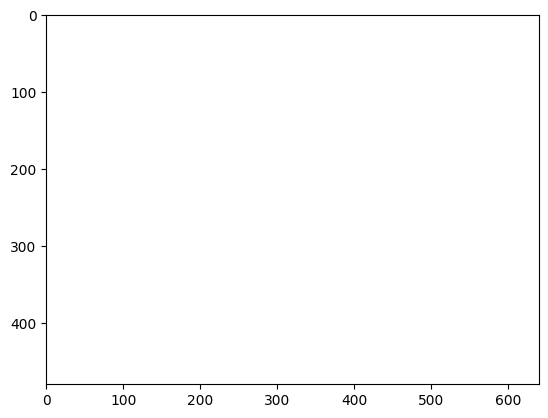

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


None


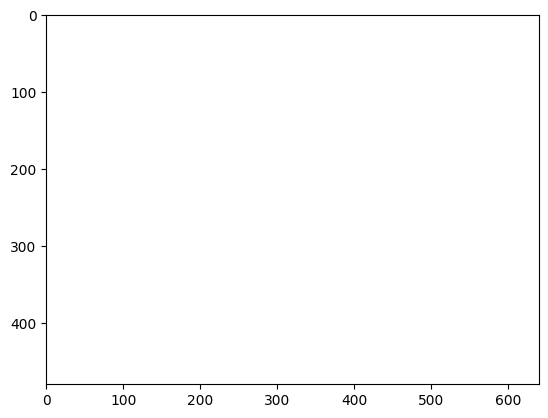

InvalidArgumentError: Value for attr 'T' of float is not in the list of allowed values: uint8, uint16
	; NodeDef: {{node EncodePng}}; Op<name=EncodePng; signature=image:T -> contents:string; attr=compression:int,default=-1; attr=T:type,default=DT_UINT8,allowed=[DT_UINT8, DT_UINT16]> [Op:EncodePng]

In [417]:
if __name__ == '__main__':
    image = imread("../../images","2.png")
    image = tf.image.resize(image,[480,640])
    
    image = random_broken(image, radius=10)
    imshow(image)

    gaussian_image = gaussian_filter(image,sigma=0.07)
    imshow(gaussian_image)

    guided_image = guided_filter(image,guide=gaussian_image,radius=10,eps=0.05)
    imshow(guided_image)
    
    imsave(image,"4.png","../../images")
    